In [1]:
import SimulateGroupDelayDispersive as gd_sim
import ricg
import matplotlib.pyplot as plt
import matplotlib.colors as colors


from ricg.augd import EquilibriumKK

import numpy as np

/afs/ipp-garching.mpg.de/aug/ads/lib64/amd64_sles11/libsfh8.so: undefined symbol: sfopenro
/afs/ipp-garching.mpg.de/aug/ads/lib64/amd64_sles11/libsfh8.so: undefined symbol: sfhhwinfoi
/afs/ipp-garching.mpg.de/aug/ads/lib64/amd64_sles11/libsfh8.so: undefined symbol: sfhmodparstatus


In [55]:
def getDensityInput(shotnumber, time, diagname='LIN', signalname='ne'):
    """
    Reads the lithium beam density data and returns:
    
    
    Returns
    ---
    r, z : 
        Cylindrical coordinates of the density points
    ne :
        density at r,z
    bfield :
        magnetic field at r,z
    
    """

    angle = 0
    
    # Equilibrium access object
    eq = EquilibriumKK(shotnumber)

    
    # Lithium beam LIN
    lin_data = ricg.get_diagSignal(diagname, signalname,shotnumber)
    tidx = ricg.common.closest_index(lin_data.time,time)
    
    ne = lin_data.data[tidx]
    rhop = lin_data.area[tidx]

    # At z = 0
    r, z = eq.get_kkRhop2RZ(time, rhop, angle)
    _, _, bfield = eq.get_kkBrzt(time, r, z)

    return r, z, rhop, ne, bfield

def getDensityRICG(shotnumber, antenna, time, persistence=4):
    """
    Reads RICG density data and
    
    Returns
    ---
    r, z:
        Coordinates of density profile
    rhop:
        
    ne:
    
    bfield:
    """
    
    eq = EquilibriumKK(shotnumber)
    #persistence = 40
    shot = ricg.RICG(shotnumber=shotnumber, antenna=antenna, time=time, persistence=persistence)
    #shot.params.stft_window = 128
    #shot.params.stft_window = 214
    #shot.params.stft_window = 214/2
    #shot.params.stft_window = 300
    #shot.params.stft_window = 350
    for _ in range(persistence):
        shot.processProfile()
        shot.nextSweep()

    los_r = shot.los.r
    los_z = shot.los.z
    los_ra = shot.los.ra
    los_rhop = eq.get_kkRZ2Rhop(time, los_r, los_z)
    los_b = shot.los_b
    los_ne = shot.ne
    return shot
    
    

def calculateGroupDelayFromNe(r, ne, b,
                totalx=600, totalfc=600, totaldg=10, f1=30e9,f2=85e9):
    """
    Simulates group delay from density profile:
        Reconstructs refractive index of medium in the radius range and for the given cut off frequencies
        Calculates the group delay for a wave propagating in this medium.
        
    Returns
    ---
    Dictionary with:
        'r'
        'ne'
        'b'
        'fc'
        'N'
        'delay'
        'phase'
    """
    

    # Create cut off frequency array
    fc = np.linspace(f1,f2,totalfc)
    
    # Interpolate the density and magnetic profiles to the number of x points 
    newr = np.linspace(r[0],r[-1],totalx)
    ne = np.interp(newr,r,ne)
    b = np.interp(newr,r,b)
    r = newr

    
    # Calculate the refractive index matrix
    N  = gd_sim.createRefractiveMatrix(r, ne, b, fc)

    phase = gd_sim.calc_phase(r,fc,N)

    delay = gd_sim.calc_delay(fc,phase)
    #print delay

    dp_fc, dp_dg = calcXmodeUpperCutoff(fc, delay, ne_ff=0)
    
    out = dict(
            r=r,
            ne=ne,
            b=b,
            fc=fc,
            N=N,
            delay=delay,
            phase=phase,
            dp_fc=dp_fc,
            dp_dg=dp_dg
            )
    return out


def calcXmodeUpperCutoff(fc, delay, ne_ff=0):
    """
        Calculates the upper cut off group delay from the original group delay measurement
    """

    ff = gd_sim.estimate_ff(fc,delay)
    fce0 = gd_sim.estimate_fce0(fc,delay)
    fce0 = gd_sim.estimate_residualfce0(ff,ne_ff)

    dp_fc,dp_dg = gd_sim.calc_ReflectionSignal(fc,delay,ff)
    
    return dp_fc, dp_dg


In [3]:
time = 2.59
time = 3.22
#time = 3.5
#time = 3.1
#time = 2
shotnumber = 34283
shotnumber = 34290

#time = 3.11
#shotnumber = 34288

antenna = 1
angle = 0


In [4]:
eq = EquilibriumKK(shotnumber)

/afs/ipp/aug/ads-diags/common/python/lib/dd.py:117: RuntimeWarning: Warning by DDcsgrp (8.1): No PARAM_SET found
  warnings.warn(text.replace('\x00','').strip(), RuntimeWarning)


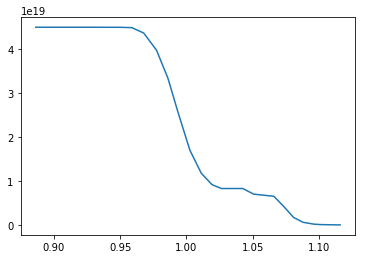

In [5]:

lin_r, lin_z, lin_rhop, lin_ne, lin_bfield= getDensityInput(shotnumber, time)
plt.plot(lin_rhop,lin_ne);plt.show()
#print lin_ne,np.flipud(lin_rhop)

In [6]:
# Convert lithium rhop to ric r, z, ra
"""
los_r = shot.los.r
los_z = shot.los.z
los_ra = shot.los.ra
los_rhop = eq.get_kkRZ2Rhop(time, los_r, los_z)
los_b = shot.los_b
"""
#print los_b

los_r, los_z, los_rhop, los_ne, los_b = getDensityRICG(shotnumber, antenna, time, persistence=40)

"""
lin2_ne = np.interp(np.flipud(los_rhop), np.flipud(lin_rhop), np.flipud(lin_ne))
lin2_ne = np.flipud(lin2_ne)
lin2_rhop = lin_rhop
lin2_ra = los_ra


if 1:
    rlin, zlin = los_r,los_z
    bfield = los_b
    nelin = lin2_ne
    rhop = lin2_rhop
"""
#print lin2_ne,lin2_rhop

#lin_ne = np.interp(los_r,)

'\nlin2_ne = np.interp(np.flipud(los_rhop), np.flipud(lin_rhop), np.flipud(lin_ne))\nlin2_ne = np.flipud(lin2_ne)\nlin2_rhop = lin_rhop\nlin2_ra = los_ra\n\n\nif 1:\n    rlin, zlin = los_r,los_z\n    bfield = los_b\n    nelin = lin2_ne\n    rhop = lin2_rhop\n'

In [7]:

if 0:
    print 'ff',ff,'fce0',fce0

    los_ra = r
    los_b = b

    print "Origineal ne shape: %d" % (ne.shape)
    print "Origineal r shape: %d" % (r.shape)
    estimated_dvac = gd_sim.estimate_vacuumDistance(los_ra, gd_sim.calc_fce(los_b), fce0)

    estimated_dvac = 0

    dp_fc,dp_dg = gd_sim.calc_ReflectionSignal(fc,delay,ff)

    newfc = np.linspace(dp_fc[0],dp_fc[-1],totaldg)
    newdg = np.interp(newfc,dp_fc,dp_dg)
    #dp_fc = newfc
    #dp_dg = newdg

    dgvac = gd_sim.calc_delayVacuum(estimated_dvac)
    print 'Removing dvac from reflection, d=',estimated_dvac,'dgvac=',dgvac
    print 'Estimated dvac',estimated_dvac,'ff',ff,'fce0',fce0

    dp_dg = dp_dg-dgvac

    pr_re,pr_ne,pr_br = gd_sim.calc_invertProfile(dp_fc, dp_dg, 
                                                  los_ra,los_b, 
                                                  dvacuum=estimated_dvac,
                                                  fce0=fce0)



    pr_dg = gd_sim.calc_delayVacuum(pr_re)
    #print pr_ne
    #fc = fc/1e9

    r_error = gd_sim.calc_error(pr_ne,pr_re,ne,r)
    ne_error = 1e19

    print 'Radial error. Mean:',r_error.mean(),'Std:',r_error.std()

#print r_error



In [18]:

data = calculateGroupDelayFromNe(lin_r[0]-lin_r, lin_ne, lin_bfield)


Calculating refractive matrix 	 100 %   


In [19]:

dp_fc = data['dp_fc']
dp_dg = data['dp_dg']
fc = data['fc']
delay = data['delay']
r = data['r']
b = data['b']
ne = data['ne']

pr_re, pr_ne, pr_br = gd_sim.calc_invertProfile(dp_fc, dp_dg, r, b)

Inverting Profile 	 100 %     


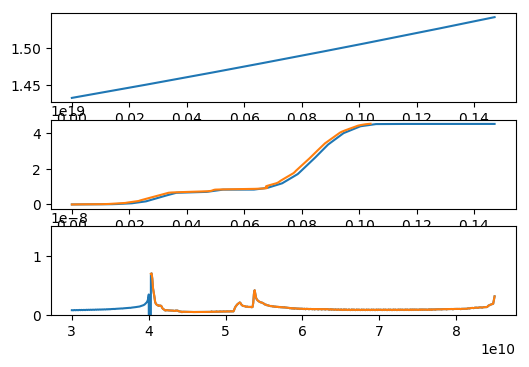

In [20]:
dp_fc = data['dp_fc']
dp_dg = data['dp_dg']
fc = data['fc']
delay = data['delay']
r = data['r']
b = data['b']
ne = data['ne']



#plt.clf()
fig,axarr = plt.subplots(3,1,dpi=100)

ax = axarr[0]
ax.plot(r, b)

ax = axarr[1]

ax.plot(r,ne)
ax.plot(pr_re,pr_ne)


ax = axarr[2]
ax.plot(fc, delay,)
ax.plot(dp_fc, dp_dg,)

plt.ylim(ymin=0)
plt.show()
#ax.pcolormesh(fc/1e9,r,N.T, cmap='Oranges',norm=colornorm)




Inverting profile for bfield[0]
Inverting Profile 	 100 % 
Inverting profile for bfield[1]
Inverting Profile 	 100 %  
Inverting profile for bfield[2]
Inverting Profile 	 100 %   
Inverting profile for bfield[3]
Inverting Profile 	 100 % 


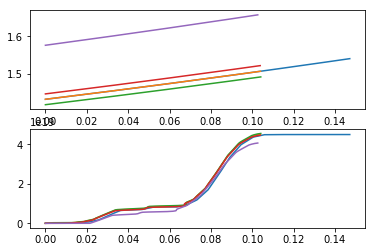

In [24]:

dp_fc = data['dp_fc']
dp_dg = data['dp_dg']
fc = data['fc']
delay = data['delay']
r = data['r']
b = data['b']
ne = data['ne']


newb = np.linspace(b[0], 3, num=len(b))

list_bfields = [b, b*0.99, b*1.01,b*1.1]
total = len(list_bfields)

f,axarr = plt.subplots(2,1,)

ax = axarr[0]
ax.plot(r, b, label='Original')
# Plotting ne profile
ax = axarr[1]
ax.plot(r, ne, label='Original')


for i, bfield in enumerate(list_bfields):
    # Calculating profile
    print 'Inverting profile for bfield[%d]'%i
    pr_re, pr_ne, pr_br = gd_sim.calc_invertProfile(dp_fc, dp_dg, r, bfield)
    
    # Plotting b profile
    ax = axarr[0]
    ax.plot(pr_re, pr_br)
    #ax.plot(r, bfield)
    
    
    # Plotting ne profile
    ax = axarr[1]
    ax.plot(pr_re, pr_ne)

#plt.figure()
#for i, bfield in enumerate(list_bfields):
#    plt.plot(r,bfield)
plt.show()

In [41]:
def calcRawSignalFromDelay(delay,sweeprate=28e9/15e-6,fs=200e6):
    
    fb = delay*sweeprate
    phasediff = np.zeros(len(fb))
    
    for i in range(len(delay)):
        phasediff[i] = fb[i]*2*np.pi/fs
    phase = np.cumsum(phasediff)
    phase = np.unwrap(phase)
    return phase

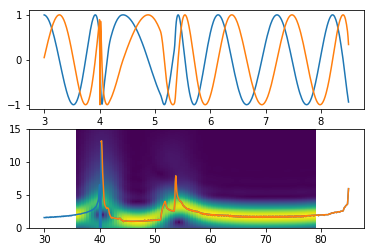

In [84]:
sweeprate = 28e9/15e-6
phase = calcRawSignalFromDelay(delay,sweeprate=sweeprate)
amplitude = 1
signal = amplitude * np.exp(1j*phase)

stft_pf, stft_fb, stft = ricg.stft(fc,signal,Fs=200e6,padding=4096,step=5,window=128,windowtype=3)
f,axarr = plt.subplots(2,1)
plt.sca(axarr[0])
plt.plot(fc,signal.real)
plt.plot(fc,signal.imag)
plt.sca(axarr[1])
plt.pcolormesh(stft_pf/1e9, stft_fb/1e6, stft)
plt.plot(fc/1e9, delay*sweeprate/1e6,)
plt.plot(dp_fc/1e9, dp_dg*sweeprate/1e6,)

plt.ylim(0,15)
plt.show()

In [81]:
# Side by side comparison of fake stft and real stft
shot = getDensityRICG(shotnumber, antenna, time, persistence=1)

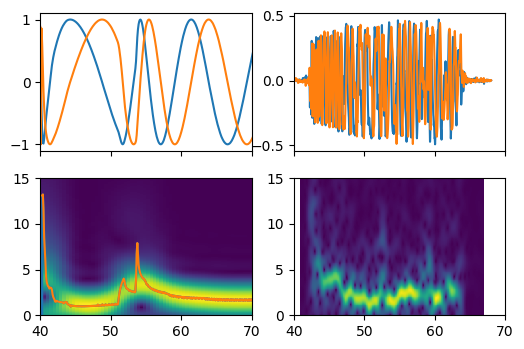

In [85]:
f,axarr = plt.subplots(2,2,dpi=100, sharex=True)
plt.sca(axarr[0,0])
plt.plot(fc/1e9,signal.real)
plt.plot(fc/1e9,signal.imag)
plt.sca(axarr[1,0])
plt.pcolormesh(stft_pf/1e9, stft_fb/1e6, stft)
plt.plot(fc/1e9, delay*sweeprate/1e6,)
plt.plot(dp_fc/1e9, dp_dg*sweeprate/1e6,)
plt.ylim(0,15)

plt.sca(axarr[0,1])
plt.plot(shot.freqramp/1e9,shot.signal.real)
plt.plot(shot.freqramp/1e9,shot.signal.imag)
plt.sca(axarr[1,1])
plt.pcolormesh(shot.stft_pf/1e9, shot.stft_fb/1e6, shot.stft)
#plt.plot(fc/1e9, delay*sweeprate/1e6,)
#plt.plot(dp_fc/1e9, dp_dg*sweeprate/1e6,)
plt.ylim(0,15)
plt.xlim(40,70)


plt.show()

In [12]:
plt.clf()
fig,axarr = plt.subplots(2,2,sharex='col',figsize=(10,10))#, sharex='col',sharey='row')
colornorm = colors.LogNorm(vmin=0.003,vmax=1)
colornorm = colors.Normalize(vmin=0,vmax=1)


ax = axarr[0,0]
ax.fill_betweenx(pr_ne/1e19, pr_re-r_error, pr_re+r_error,facecolor='red',alpha=0.1)
ax.plot(r,ne/1e19,label='Original',c='b',lw=2)
ax.plot(pr_re,pr_ne/1e19,label='Calculated',c='r',lw=1)

ax.plot(shot.ra,shot.ne/1e19, label='RIC')

ax.plot(lin2_ra,lin2_ne/1e19, label='LIN')

ax.set_ylabel('Ne [1e19m-3]')
ax.legend(fontsize='x-small',loc=2)
ylim_ne = [0,12]
#ax.set_ylim(ylim_ne)

ax = axarr[1,0]
ax.plot(r,b,label='Original',c='b',lw=2)
ax.plot(pr_re,pr_br,label='Calculated',c='r',lw=1)
ax.set_ylabel('B [T]')
ax.legend(fontsize='x-small',loc=4)
ax.set_xlim([r.min(),r.max()])
ax.set_xlabel('Radius [m]')

ax = axarr[0,1]
ax.pcolormesh(fc/1e9,r,N.T, cmap='Oranges',norm=colornorm)
ax.set_ylabel('Radius [m]')
ax.set_title('X-mode dispersion',fontsize='x-small')
ax.set_ylim([r.min(),r.max()])

ax = axarr[1,1]

ax.pcolormesh(shot.stft_pf/1e9,shot.stft_dg*1e9,shot.stft)
ax.plot(shot.dp_fc/1e9,shot.dp_dg*1e9,c='r')


ax.plot(fc/1e9,delay*1e9,c='b',lw=2,label='Delay of original')
ax.plot(dp_fc/1e9,dp_dg*1e9,c='r',lw=1,label='Upper cutoff delay')
ax.axvline(ff/1e9,c='c',label='First fringe reflection')
ax.plot(dp_fc/1e9,pr_dg*1e9,c='g',label='Vacuum delay from profile')
ax.set_ylim([-0.1,np.max(delay*1e9)*1.2])
ax.set_ylabel('Delay [ns]')
ax.legend(fontsize='x-small')
ax.set_xlabel('Probing frequency [GHz]')

ax.set_xlim([39,70])
ax.set_ylim([0,8])

plt.suptitle('Simulation of X-mode profile inversion')
print 'Removing dvac from reflection, d=',estimated_dvac,'dgvac=',dgvac
print 'fce0 ff',fce0,ff
print 'fce(dvac), fce(estimateddvac)',gd_sim.calc_fce(np.interp(dvac,los_ra,los_b)),gd_sim.calc_fce(np.interp(estimated_dvac,los_ra,los_b))
plt.show()

NameError: name 'r_error' is not defined

In [ ]:
shot.params.pfspan/1e9
shot.params.stft_window = 128
shot.params.stft_window 